In [1]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

## tvAR(1) 

\begin{equation}
X_{t, T} + \alpha(\frac{t}{T}) X_{t-1, T} = \sigma(\frac{t}{T}) \epsilon_t
\end{equation}

### Define $\alpha (t)$

For all $t \in [0, 1], \; \alpha(t) \in (-1, 1)$

In [2]:
def alpha(t):
    return -0.8 * np.cos(1.5 - np.cos(4 * np.pi * t))

def sigma(t): 
    return np.cos(t * np.pi / 2 + np.exp(t)) ** 2

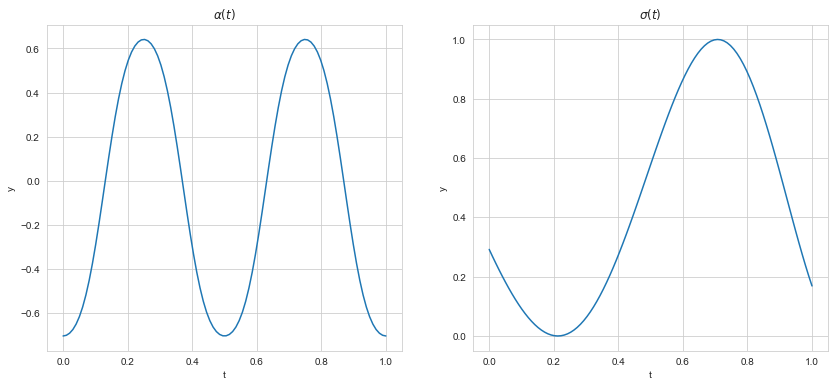

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

t = np.linspace(0, 1, 100)

sns.lineplot(x=t, y=alpha(t), ax=axs[0]);
sns.lineplot(x=t, y=sigma(t), ax=axs[1]);

axs[0].set_title(r"$\alpha(t)$")
axs[1].set_title(r"$\sigma(t)$")

for ax in axs.flat:
    ax.set_xlabel("t");
    ax.set_ylabel("y");

In [4]:
def simulate_tvAR_p(X_0, T, alpha_fun, sigma_fun, epsilon):
    X = np.empty(shape=(T,))
    X[0] = X_0
    
    for t in range(1, T):
        alpha_t = alpha_fun(t / T)
        sigma_t = sigma_fun(t / T)
        X[t] = X[t-1] * (-alpha_t) + sigma_t * epsilon[t]
        
    return X

### Application

In [5]:
T = 500
t_0 = 200 
u = t_0 / T

np.random.seed(1234)
epsilon = np.random.normal(0, 1, size=T) # noise used to generate X_t and X_tilde

# X_t
realization = simulate_tvAR_p(0, T, alpha, sigma, epsilon)

# X_tilde_t
realization_x_tilde = simulate_tvAR_p(0, T, lambda t: alpha(u), lambda t: sigma(u), epsilon)

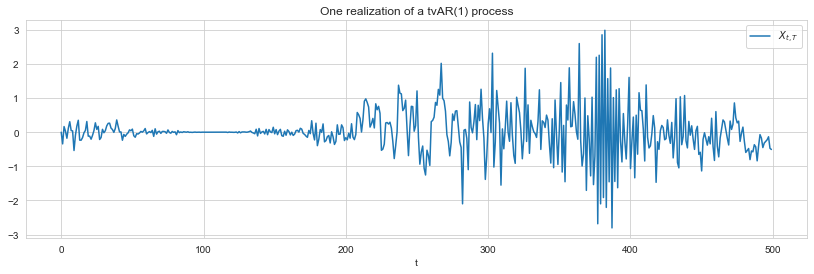

In [6]:
# only X_{t, T}
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(realization, label=r"$X_{t,T}$");
ax.set_xlabel("t");
ax.set_title("One realization of a tvAR(1) process");
ax.legend();

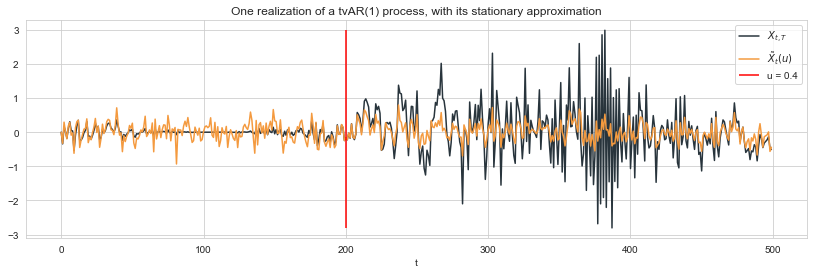

In [7]:
# X_{t, T} and X_tilde
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realization, label=r"$X_{t,T}$", color="#28343c");
ax.plot(realization_x_tilde, label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realization.min(), ymax=realization.max(), color='red', label=f"u = {u}")

ax.set_xlabel("t");
ax.set_title("One realization of a tvAR(1) process, with its stationary approximation");
ax.legend();

# plt.savefig("tvAR-1-example-full.pdf", bbox_inches="tight")

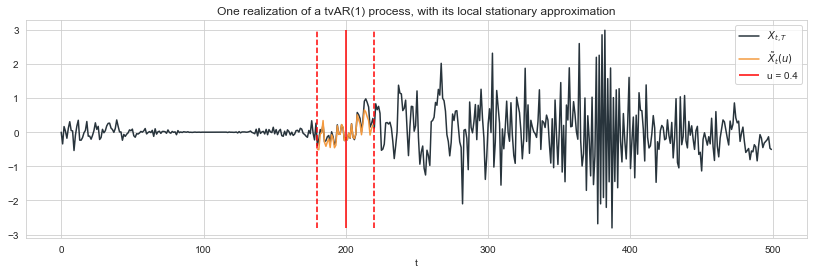

In [8]:
x_min = t_0 - 20
x_max = t_0 + 20

# figure
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realization, label=r"$X_{t,T}$", color="#28343c");
ax.plot(range(x_min, x_max), realization_x_tilde[x_min:x_max], label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realization.min(), ymax=realization.max(), color='red', label=f"u = {u}")
ax.vlines(x_min, ymin=realization.min(), ymax=realization.max(), color='red', linestyle='--')
ax.vlines(x_max, ymin=realization.min(), ymax=realization.max(), color='red', linestyle='--')

ax.set_xlabel("t");
ax.set_title("One realization of a tvAR(1) process, with its local stationary approximation");
ax.legend();

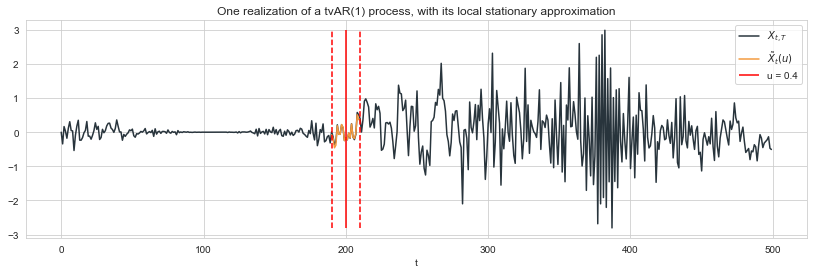

In [9]:
x_min = t_0 - 10
x_max = t_0 + 10

# figure
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realization, label=r"$X_{t,T}$", color="#28343c");
ax.plot(range(x_min, x_max), realization_x_tilde[x_min:x_max], label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realization.min(), ymax=realization.max(), color='red', label=f"u = {u}")
ax.vlines(x_min, ymin=realization.min(), ymax=realization.max(), color='red', linestyle='--')
ax.vlines(x_max, ymin=realization.min(), ymax=realization.max(), color='red', linestyle='--')

ax.set_xlabel("t");
ax.set_title("One realization of a tvAR(1) process, with its local stationary approximation");
ax.legend();

# plt.savefig("tvAR-1-example.pdf", bbox_inches="tight")

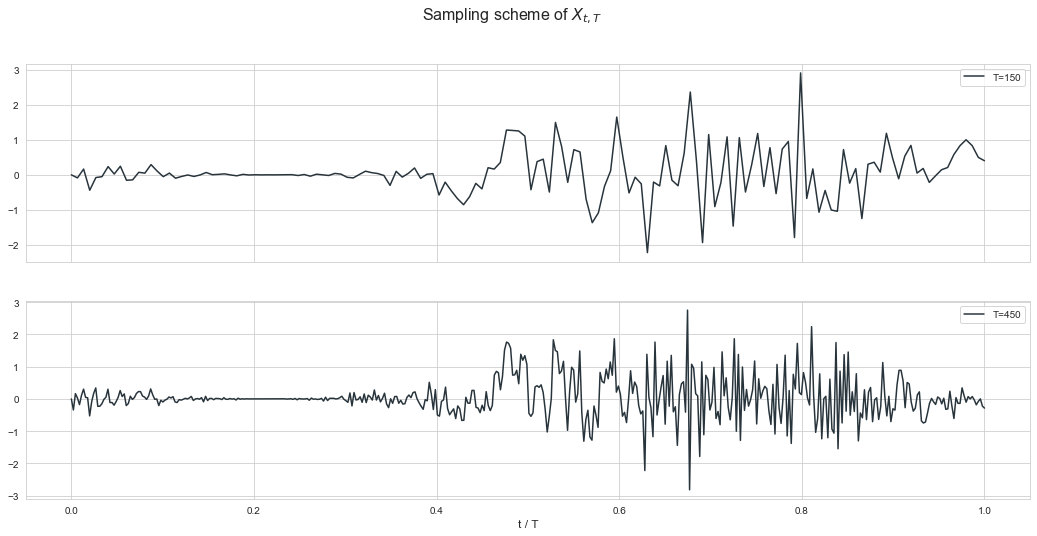

In [26]:
T_1 = 150
T_2 = 450

np.random.seed(1234)
epsilon_2 = np.random.normal(0, 1, size=T_2) 
epsilon_1 = epsilon_2[::int(T_2 / T_1)]

# X_t
realization_1 = simulate_tvAR_p(0, T_1, alpha, sigma, epsilon_1)
realization_2 = simulate_tvAR_p(0, T_2, alpha, sigma, epsilon_2)

# figure
fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

axs[0].plot(np.linspace(0, 1, len(realization_1)), realization_1, label=f"T={T_1}", color="#28343c");
axs[1].plot(np.linspace(0, 1, len(realization_2)), realization_2, label=f"T={T_2}", color="#28343c");

fig.suptitle("Sampling scheme of " + r"$X_{t,T}$", fontsize=16);
axs[1].set_xlabel("t / T", fontsize=12)
axs[0].legend();
axs[1].legend();

# plt.savefig("sampling-scheme.pdf", bbox_inches="tight")

## Test with pairs trading
###  COIN / BTC

In [10]:
# download data
data = yf.download("COIN BTC", start="2015-01-01")
data = data['Close']
data = data.dropna()

[*********************100%***********************]  2 of 2 completed


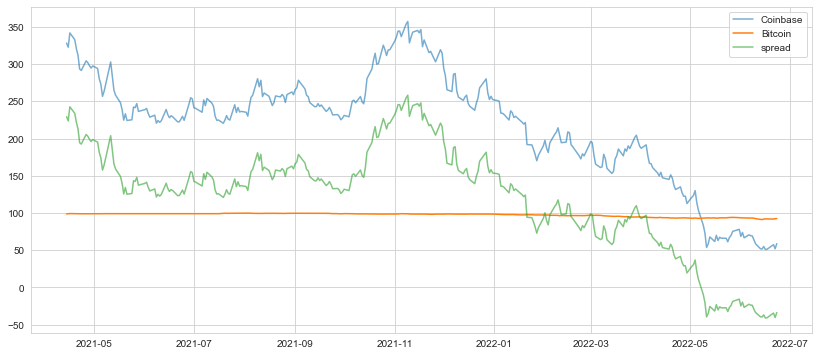

In [11]:
spread_series = data['COIN'] - data['BTC']

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data['COIN'], alpha=0.6, label="Coinbase")
ax.plot(data['BTC'], label="Bitcoin")
ax.plot(spread_series, alpha=0.6, label="spread")

ax.legend();

[*********************100%***********************]  2 of 2 completed


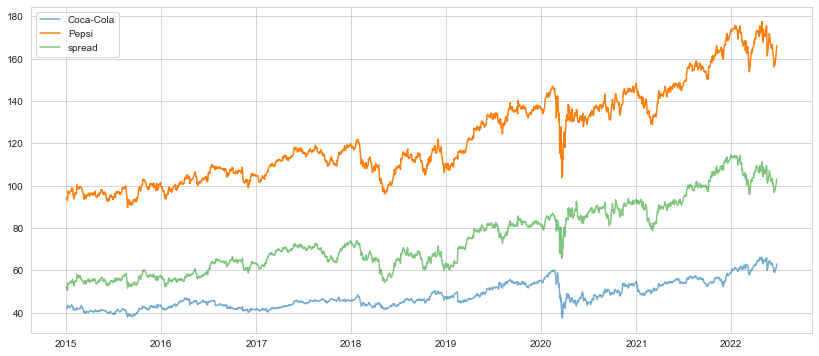

In [12]:
# download data
data = yf.download("KO PEP", start="2015-01-01")
data = data['Close']
data = data.dropna()

# plot
spread_series = data['PEP'] - data['KO']

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data['KO'], alpha=0.6, label="Coca-Cola")
ax.plot(data['PEP'], label="Pepsi")
ax.plot(spread_series, alpha=0.6, label="spread")

ax.legend();

## S&P 500

In [13]:
sp500_df = yf.download("^GSPC", start="1999-01-01")
sp500_df = sp500_df['Close']

[*********************100%***********************]  1 of 1 completed


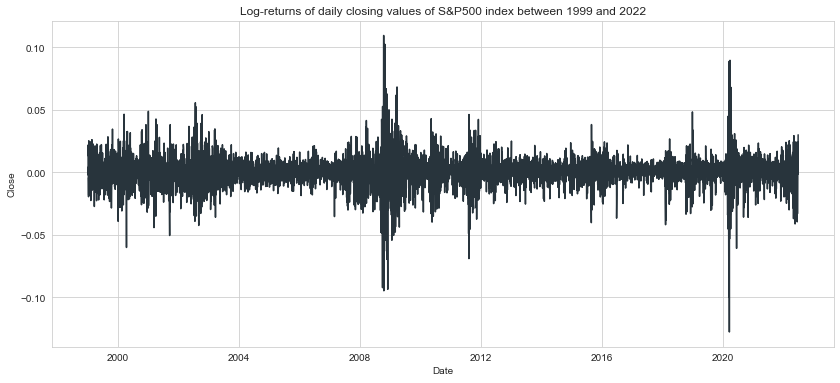

In [14]:
# daily log returns
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=np.log(1 + sp500_df.pct_change()), color="#28343c", ax=ax);
ax.set_title("Log-returns of daily closing values of S&P500 index between 1999 and 2022");

# plt.savefig("sp500-log-returns.pdf", bbox_inches="tight")

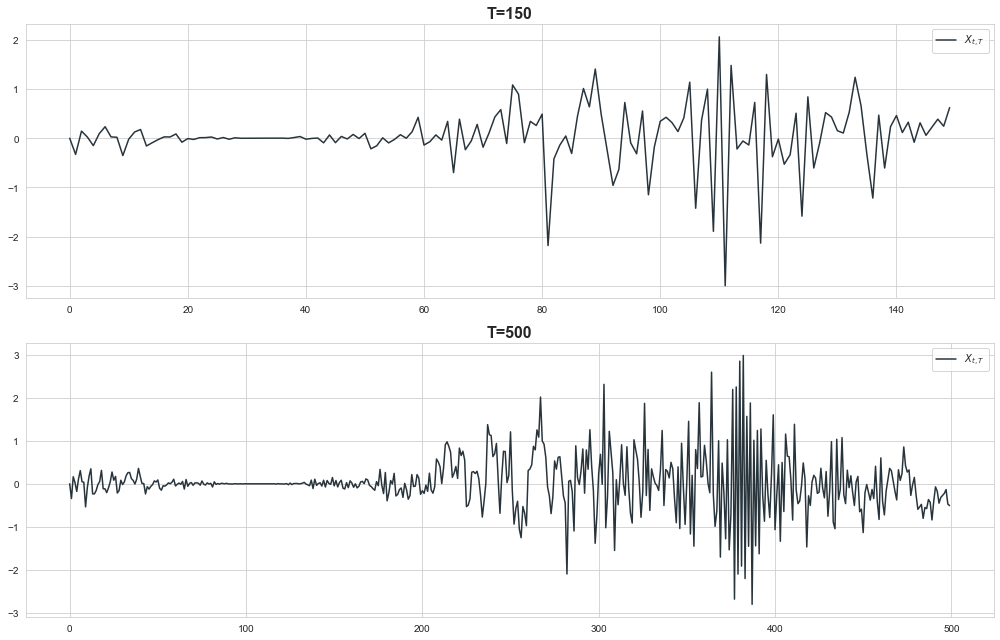

In [39]:
T_list = [150, 500]

fig, axs = plt.subplots(2, 1, figsize=(14, 9))

for i, T in enumerate(T_list):
    np.random.seed(1234)
    epsilon = np.random.normal(0, 1, size=T) # noise used to generate X_t and X_tilde

    # X_t
    realization = simulate_tvAR_p(0, T, alpha, sigma, epsilon)

    # figure
    axs[i].plot(realization, label=r"$X_{t,T}$", color="#28343c");
    axs[i].set_title(f"{T=}", fontweight='bold', fontsize=16);
    axs[i].legend();

fig.tight_layout()
# plt.savefig("process-sampling.pdf")
